# Data Analysis

In [18]:
%load_ext autoreload
%autoreload 2

# plot the reward function with plotly as line plot
import plotly.io as pio
pio.renderers.default = 'iframe'
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA
from utils import eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from utils import feature_eng, visualization

station_b_train = feature_eng.get_data_df("train", "B")

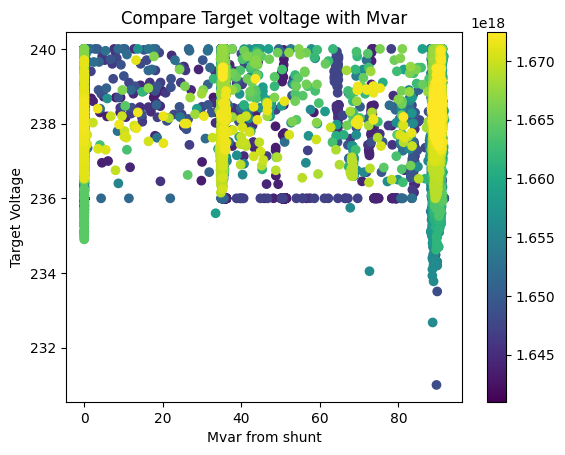

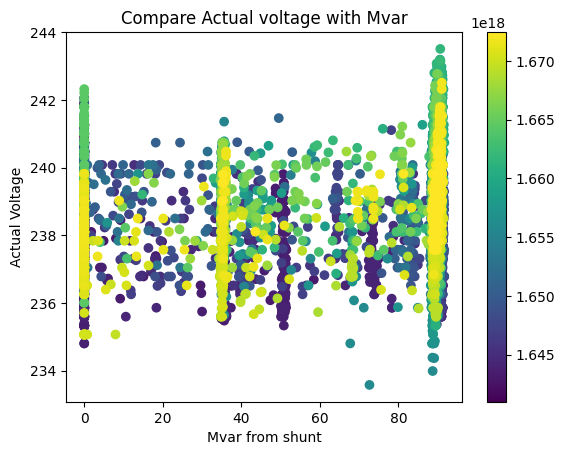

In [20]:
ist_col_name = "ZLQZLQSPHSDL_VNUUIST"
sol_col_name = "ZLQZLQSPHSDL_VNUUSOL"
switch_col_name = "ZLQZLQ110KOMDROQ"
state_change_limit = 20
tol = 0.01

plt.figure().clear()
sc = plt.scatter(station_b_train[switch_col_name], station_b_train[sol_col_name], c=station_b_train.index)
plt.xlabel("Mvar from shunt")
plt.ylabel("Target Voltage")
plt.title("Compare Target voltage with Mvar")
plt.colorbar(sc)
plt.show()

plt.figure().clear()
sc = plt.scatter(station_b_train[switch_col_name], station_b_train[ist_col_name], c=station_b_train.index)
plt.xlabel("Mvar from shunt")
plt.ylabel("Actual Voltage")
plt.title("Compare Actual voltage with Mvar")
plt.colorbar(sc)
plt.show()

In [21]:
def diff(timeserie):
    return timeserie.values[1:] - timeserie.values[0:-1]

In [22]:
switch_changes = pd.DataFrame(data=diff(station_b_train[switch_col_name]), columns=["mvar_diff"], index=station_b_train.index[1:])

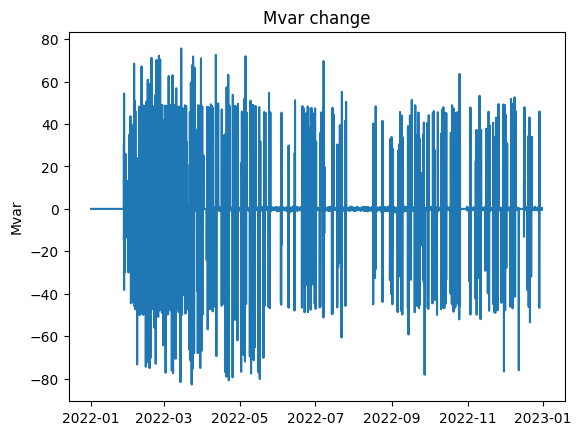

In [23]:
plt.plot(switch_changes)
plt.title("Mvar change")
plt.ylabel("Mvar")
plt.show()

## Sensitivity analysis
We want to see the influence of Mvar change on voltage.

In [ ]:
def try_model(shift=1):
    X = station_b_train[ist_col_name].diff()
    y = station_b_train[switch_col_name].diff()
    colors = station_b_train[sol_col_name].diff()
    diff = pd.DataFrame(data={"ist": X[shift:], "mvar": y[shift:], "colors": colors})

    diff = diff.fillna(0)

    #remove values near 0
    too_small_ist = diff["ist"] < tol
    too_big_ist = diff["ist"] > -tol
    diff = diff[~(too_small_ist & too_big_ist)]
    too_small_mvar = diff["mvar"] < tol
    too_big_mvar = diff["mvar"] > -tol
    diff = diff[~(too_small_mvar & too_big_mvar)]

    if shift == 0:
        y = diff["ist"].values
        X = diff["mvar"].values
        c = diff["colors"].values
    else:
        y = diff["ist"].values[shift:]
        X = diff["mvar"].values[:-shift]
        c = diff["colors"].values[shift:]

    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print("BIC : %s" % model.bic)
    
    plt.scatter(X, y)
    plt.xlabel("Mvar change [Mvar]")
    plt.ylabel("Voltage change [kV]")
    plt.title("Compare Mvar and voltage change")
    plt.plot(X, model.predict(X_const), color="red", linewidth=2)
    print(model.params)
    
    plt.show()

BIC : 12004.790161727165
[-0.01342695 -0.01336432]


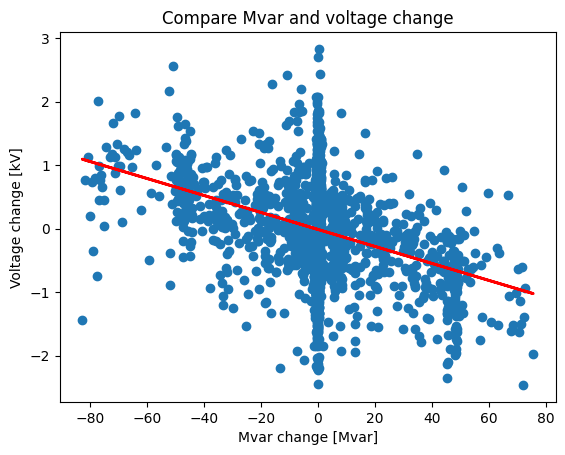

BIC : 12629.220512630603
[-0.01205287  0.00211365]


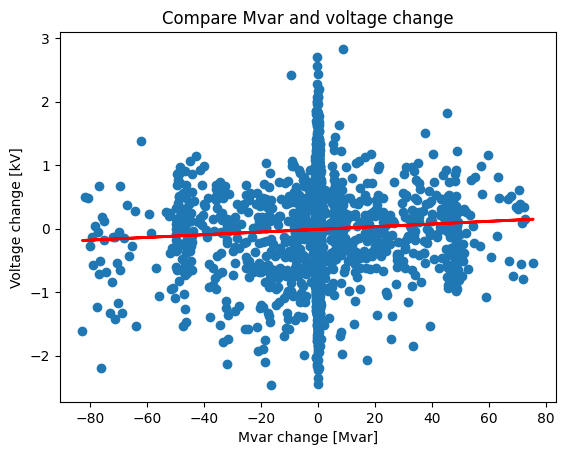

BIC : 12284.986869790364
[-0.01316456 -0.01012372]


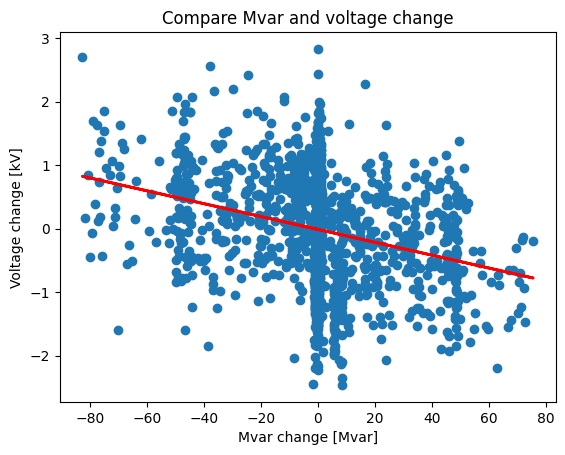

In [25]:
try_model(1)
try_model(2)
try_model(0)